In [1]:
import csv
from pathlib import Path
import os

def write_to_csv_parameters(filename):
    fieldnames = ['Date', 'Item Name', 'p', 'd', 'q']
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(fieldnames)
        
        # writer.writerow([today_date, product_name, p, d, q])
        
base_dir = Path(os.getenv("BASE_DIRECTORY"))
filename = base_dir / "ml_models/vegetables_saved_models/vegetables_parameters.csv"
write_to_csv_parameters(filename)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/vegetables/vegetables_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/vegetables_saved_models"
filename = base_dir / "ml_models/vegetables_saved_models/vegetables_parameters.csv"
allYearsFilename = base_dir / "data/vegetables/vegetables_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("VEGETABLES_WEBPAGE_PATH"),
                                            os.getenv("VEGETABLES_DATE_PATH"),
                                            os.getenv("VEGETABLES_SUBMIT_BUTTON_PATH"),
                                            os.getenv("VEGETABLES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()


# Storing models on Spaces

         Date Item Name  Low Price  Average Price  High Price
0  10-12-2024     ટમેટા        500          650.0         800
1  10-12-2024      મરચા        500          850.0        1200
2  10-12-2024     ગુવાર        600          900.0        1200
3  10-12-2024      કોબી        100          250.0         400
4  10-12-2024      દુધી         60          130.0         200
['ટમેટા' 'મરચા' 'ગુવાર' 'કોબી' 'દુધી' 'ફલાવર' 'કાકડી' 'રીંગણા' 'ભીંડો'
 'ગલકા' 'ગાજર' 'ટિંડોરા' 'તુવેર' 'વાલ' 'વટાણા' 'કેરી કાચી' 'બટેટા'
 'લીલી હળદર' 'ડુંગળી પુરા' 'તાંજરીયા પુરા' 'કોથમીર પુરા' 'મૂળા પુરા'
 'ફોદીનો પુરા' 'પચકારુ' 'ચૂ્રણ' 'ઘીસોડા' 'લીંબુ' 'મેથી પુરા' 'બીટ પુરા'
 'સરગવો પુરા' 'ચોરા' 'કારેલા' 'વાલોર' 'આદુ' 'મકાઈ ડોડા' 'લસણ પુરા'
 'પાલક પુરા' 'શક્કરીયા' 'અંબાળા' 'કાચા કેળા' 'ratalu gajar' 'કાચા પોપૈયા'
 'લીમડો પુરા' 'parvar' 'ફણશી' 'શેરડી' 'મગફળી લીલી' 'ગુંદા' 'લીલા ચણા'
 'alavipan' 'fansh' 'આંબલી']
Data older than 11-12-2024 has been removed.
Before dropping the column:
         Date Some Extra Column Item

<Figure size 1200x600 with 0 Axes>

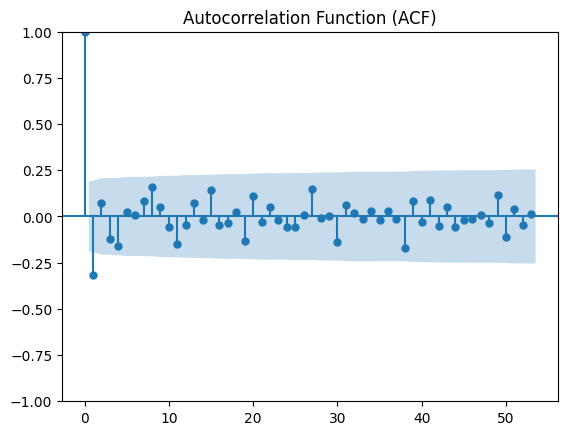

<Figure size 1200x600 with 0 Axes>

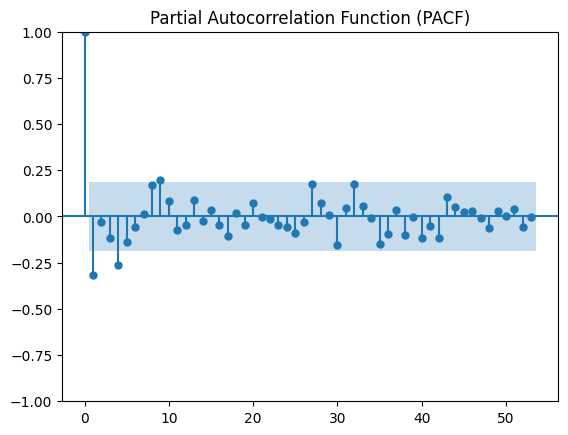


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -548.126
Date:                Thu, 10 Apr 2025   AIC                           1118.252
Time:                        21:55:55   BIC                           1147.755
Sample:                             0   HQIC                          1130.214
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1222      0.149     -0.819      0.413      -0.415       0.170
ar.L2          0.2441      0.137      1.780      0.075      -0.025       0.5

<Figure size 1200x600 with 0 Axes>

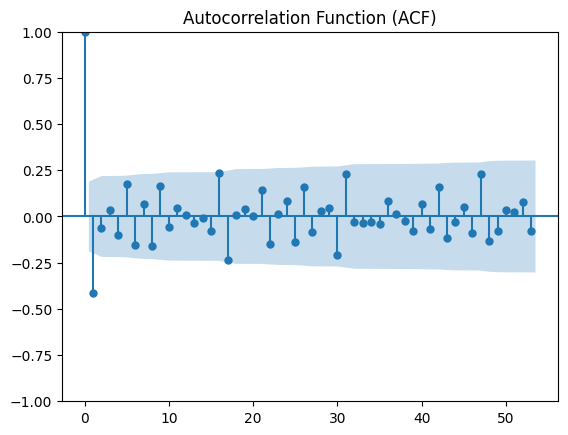

<Figure size 1200x600 with 0 Axes>

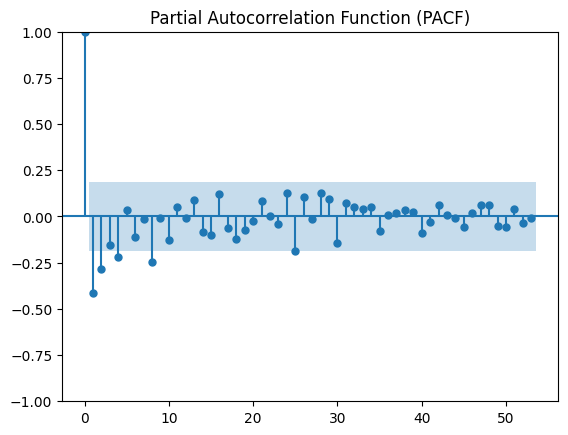


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -642.358
Date:                Thu, 10 Apr 2025   AIC                           1302.716
Time:                        21:56:08   BIC                           1326.855
Sample:                             0   HQIC                          1312.503
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8763      0.224     -3.904      0.000      -1.316      -0.436
ar.L2         -1.0270      0.196     -5.242      0.000      -1.411      -0.6

<Figure size 1200x600 with 0 Axes>

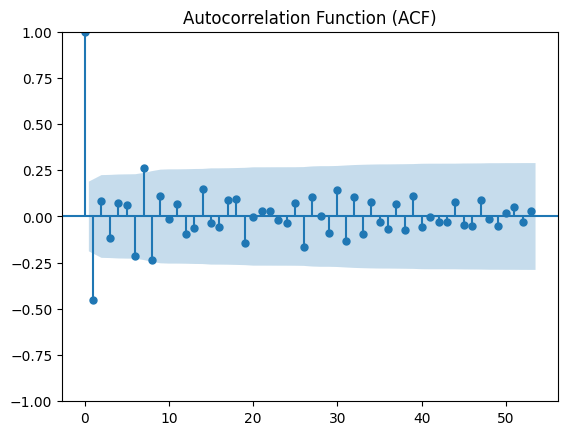

<Figure size 1200x600 with 0 Axes>

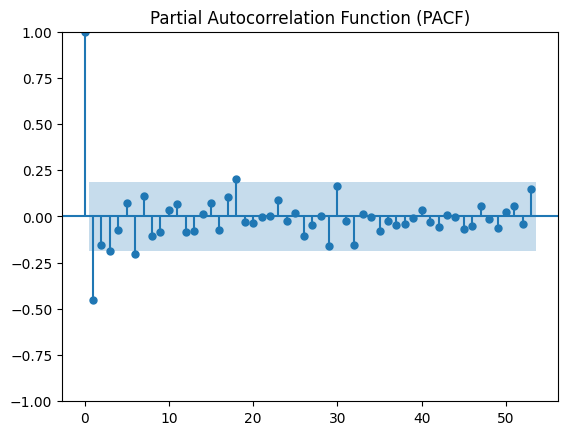


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -700.703
Date:                Thu, 10 Apr 2025   AIC                           1423.406
Time:                        21:56:17   BIC                           1452.909
Sample:                             0   HQIC                          1435.368
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5263      0.144     -3.666      0.000      -0.808      -0.245
ar.L2         -0.1407      0.127     -1.108      0.268      -0.390       0.1

<Figure size 1200x600 with 0 Axes>

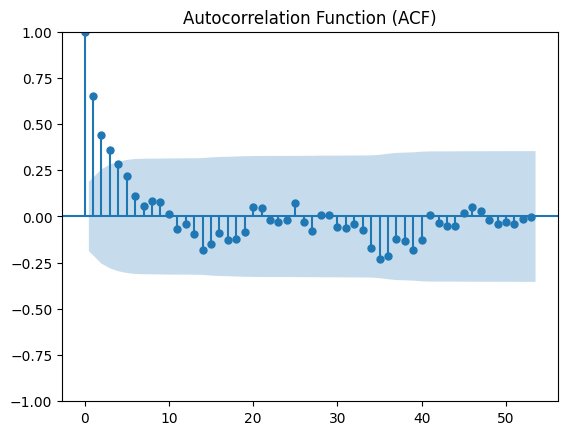

<Figure size 1200x600 with 0 Axes>

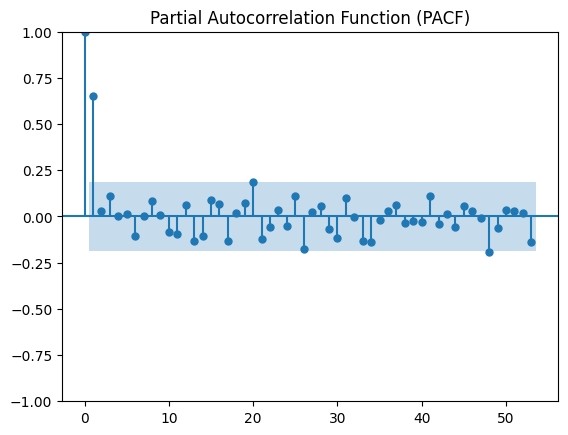


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -599.445
Date:                Thu, 10 Apr 2025   AIC                           1206.891
Time:                        21:56:32   BIC                           1217.656
Sample:                             0   HQIC                          1211.257
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.5513     22.313      5.985      0.000      89.818     177.285
ar.L1          0.7217      0.103      7.032      0.000       0.521       0.9

<Figure size 1200x600 with 0 Axes>

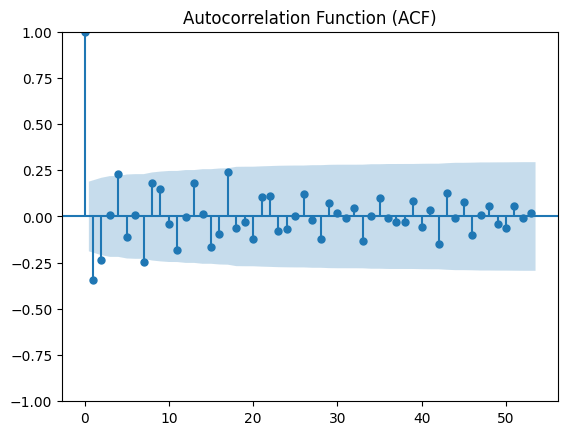

<Figure size 1200x600 with 0 Axes>

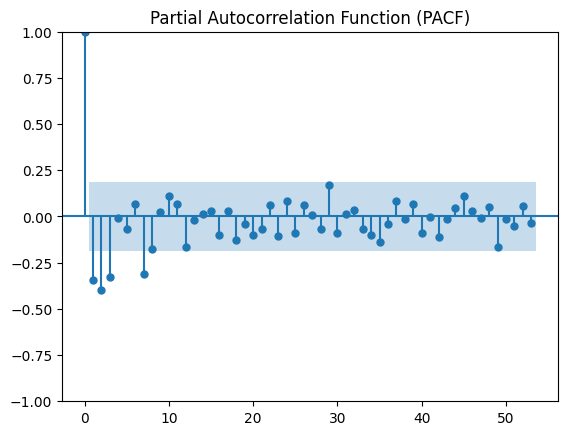


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -516.737
Date:                Thu, 10 Apr 2025   AIC                           1055.474
Time:                        21:56:48   BIC                           1084.978
Sample:                             0   HQIC                          1067.437
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1109      0.161     -6.893      0.000      -1.427      -0.795
ar.L2         -0.9436      0.239     -3.953      0.000      -1.411      -0.4

<Figure size 1200x600 with 0 Axes>

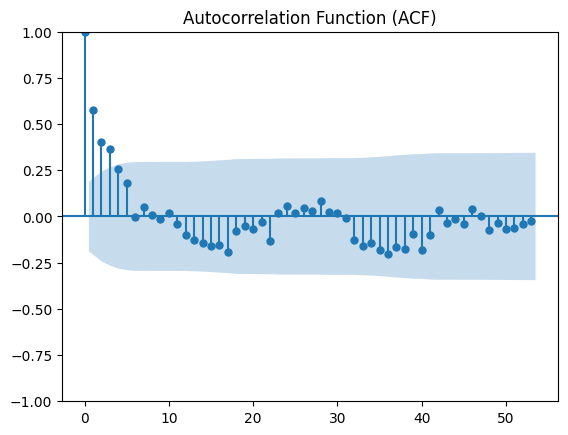

<Figure size 1200x600 with 0 Axes>

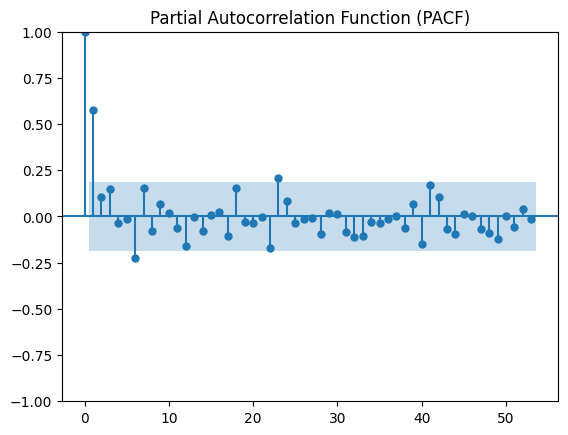


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -727.217
Date:                Thu, 10 Apr 2025   AIC                           1470.434
Time:                        21:57:04   BIC                           1491.965
Sample:                             0   HQIC                          1479.166
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        387.9791     23.156     16.755      0.000     342.593     433.365
ar.L1          0.6035      0.125      4.810      0.000       0.358       0.8

<Figure size 1200x600 with 0 Axes>

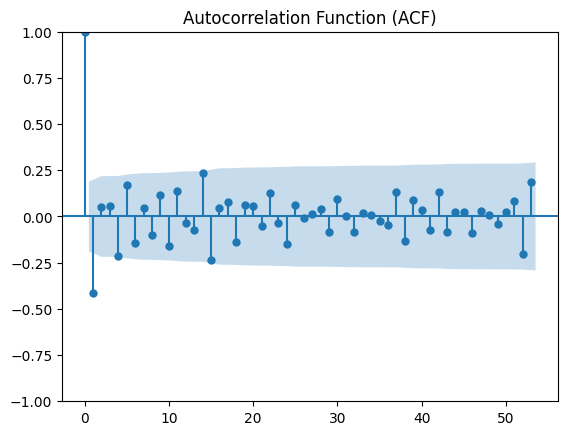

<Figure size 1200x600 with 0 Axes>

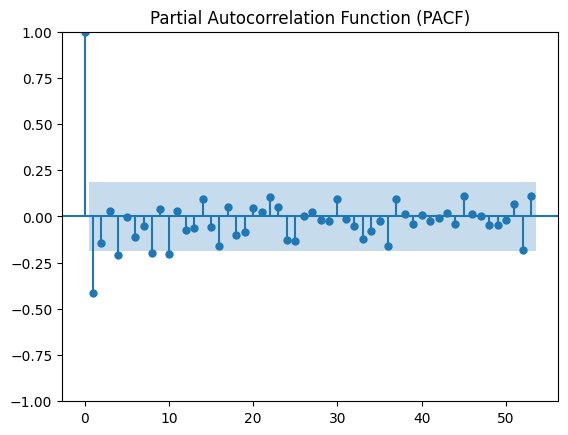


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -611.342
Date:                Thu, 10 Apr 2025   AIC                           1244.684
Time:                        21:57:17   BIC                           1274.188
Sample:                             0   HQIC                          1256.647
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0424      1.631      0.026      0.979      -3.154       3.238
ar.L2          0.0632      1.558      0.041      0.968      -2.989       3.1

<Figure size 1200x600 with 0 Axes>

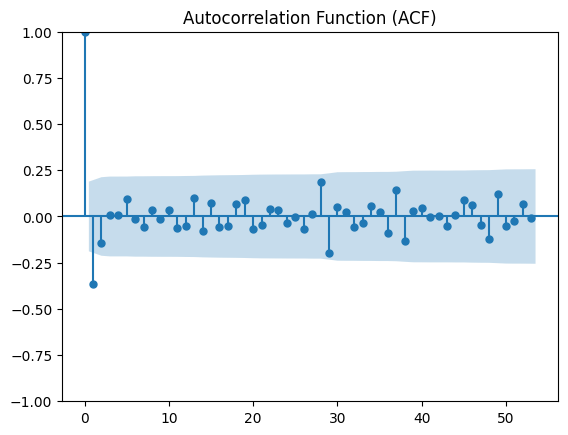

<Figure size 1200x600 with 0 Axes>

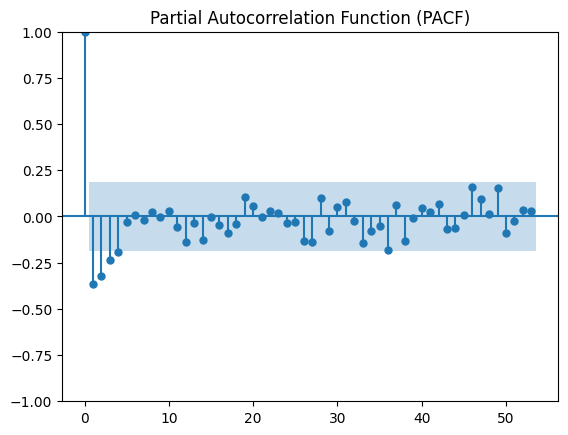


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -549.432
Date:                Thu, 10 Apr 2025   AIC                           1108.864
Time:                        21:57:24   BIC                           1122.275
Sample:                             0   HQIC                          1114.302
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6625      0.291      2.278      0.023       0.093       1.232
ar.L2         -0.3483      0.135     -2.575      0.010      -0.613      -0.0

<Figure size 1200x600 with 0 Axes>

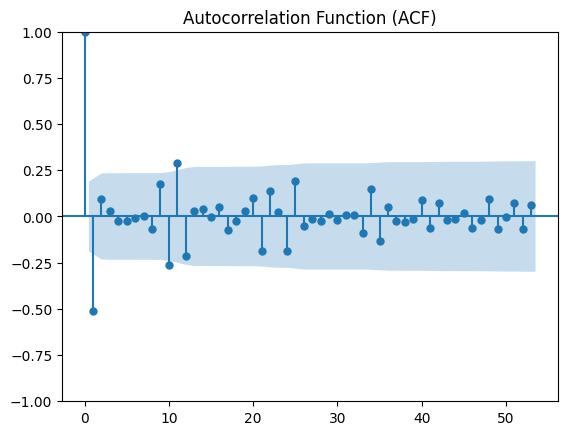

<Figure size 1200x600 with 0 Axes>

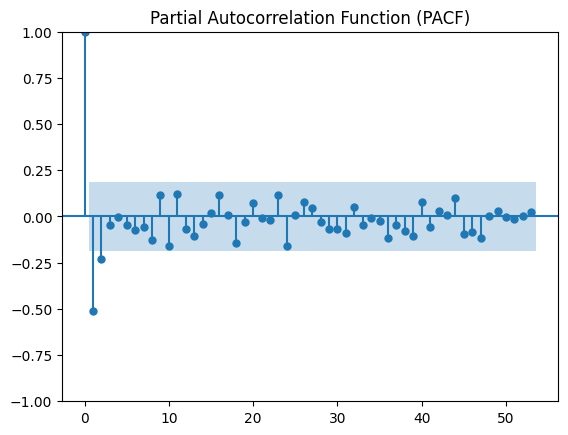


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -630.402
Date:                Thu, 10 Apr 2025   AIC                           1274.805
Time:                        21:57:35   BIC                           1293.579
Sample:                             0   HQIC                          1282.417
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3626      0.308     -1.175      0.240      -0.967       0.242
ar.L2          0.7492      0.152      4.929      0.000       0.451       1.0

<Figure size 1200x600 with 0 Axes>

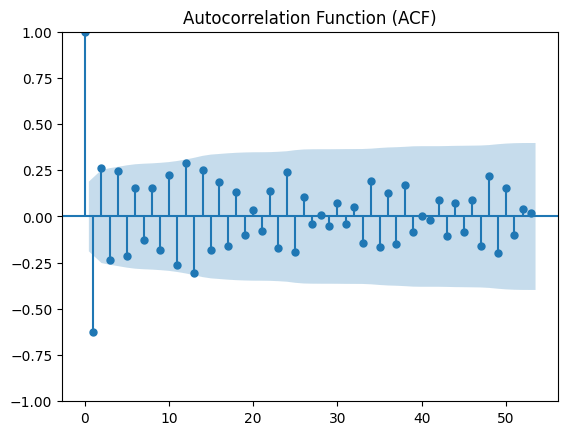

<Figure size 1200x600 with 0 Axes>

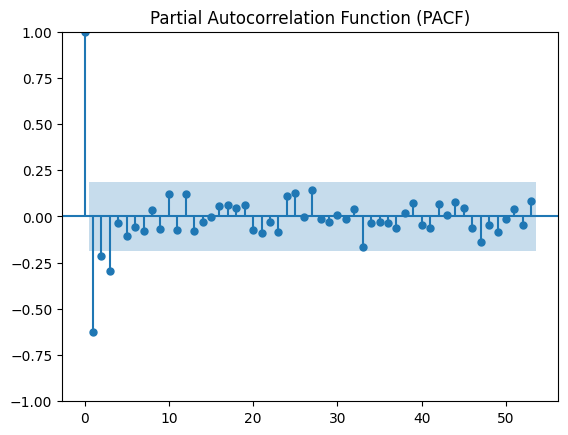


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -592.146
Date:                Thu, 10 Apr 2025   AIC                           1206.292
Time:                        21:57:40   BIC                           1235.795
Sample:                             0   HQIC                          1218.254
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6428      0.632      1.017      0.309      -0.596       1.882
ar.L2          0.0739      0.283      0.261      0.794      -0.481       0.6

<Figure size 1200x600 with 0 Axes>

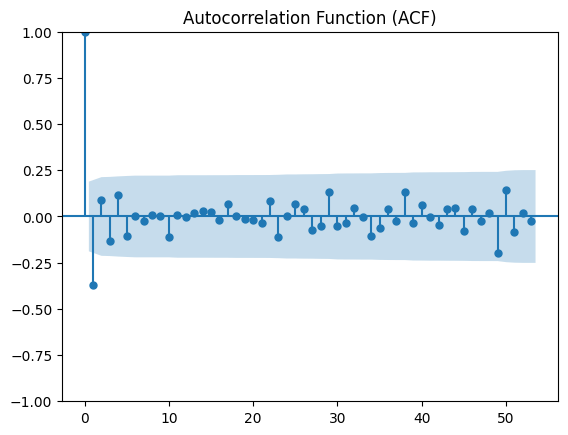

<Figure size 1200x600 with 0 Axes>

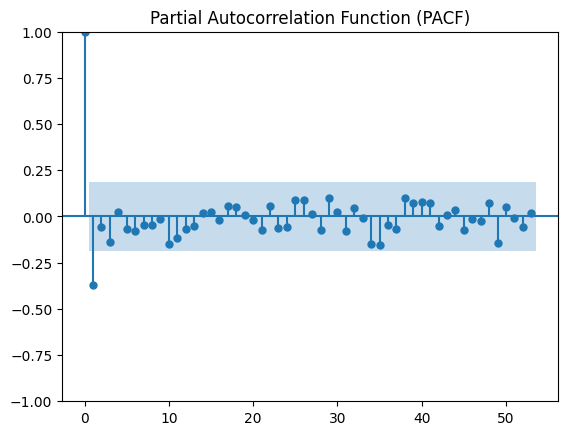


Fitting ARIMA model with order (4, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -562.290
Date:                Thu, 10 Apr 2025   AIC                           1140.579
Time:                        21:57:47   BIC                           1162.036
Sample:                             0   HQIC                          1149.279
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4783      0.212     -6.972      0.000      -1.894      -1.063
ar.L2         -0.1303      0.472     -0.276      0.783      -1.056       0.7

<Figure size 1200x600 with 0 Axes>

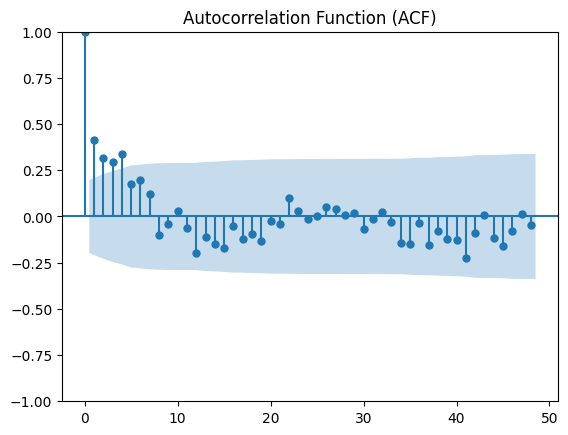

<Figure size 1200x600 with 0 Axes>

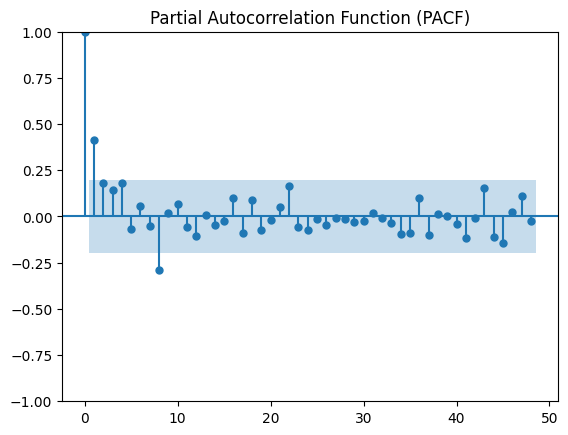


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   98
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -565.959
Date:                Thu, 10 Apr 2025   AIC                           1145.918
Time:                        21:57:58   BIC                           1164.013
Sample:                             0   HQIC                          1153.237
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.6279     16.954     29.352      0.000     464.399     530.856
ar.L1          2.1461      0.139     15.450      0.000       1.874       2.4

<Figure size 1200x600 with 0 Axes>

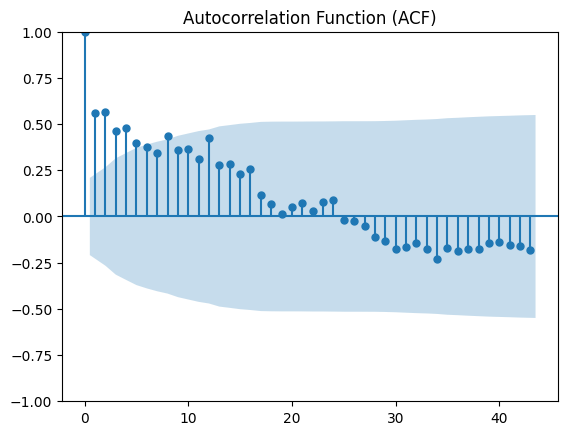

<Figure size 1200x600 with 0 Axes>

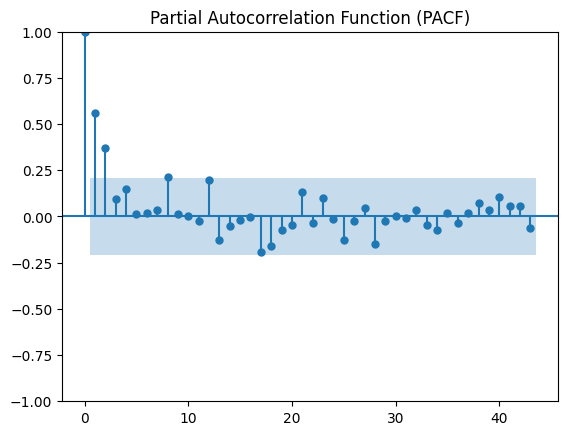


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   88
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -528.389
Date:                Thu, 10 Apr 2025   AIC                           1068.779
Time:                        21:58:02   BIC                           1083.643
Sample:                             0   HQIC                          1074.767
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        527.4796     59.989      8.793      0.000     409.904     645.055
ar.L1          0.2672      0.121      2.217      0.027       0.031       0.5

<Figure size 1200x600 with 0 Axes>

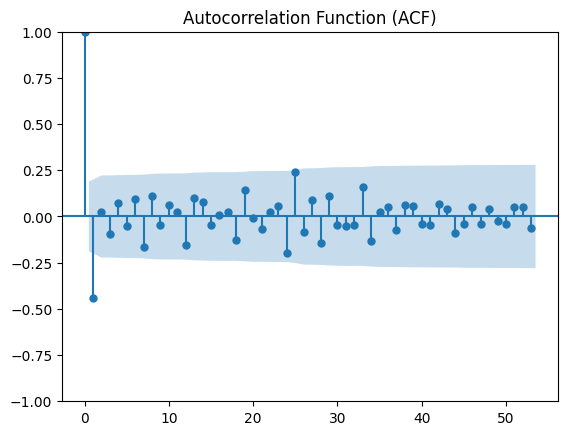

<Figure size 1200x600 with 0 Axes>

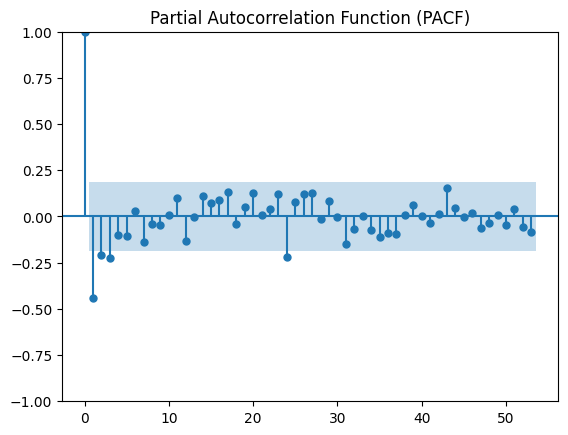


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -640.282
Date:                Thu, 10 Apr 2025   AIC                           1298.563
Time:                        21:58:09   BIC                           1322.702
Sample:                             0   HQIC                          1308.351
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8544      0.544     -1.571      0.116      -1.920       0.212
ar.L2         -0.8748      0.153     -5.702      0.000      -1.175      -0.5

<Figure size 1200x600 with 0 Axes>

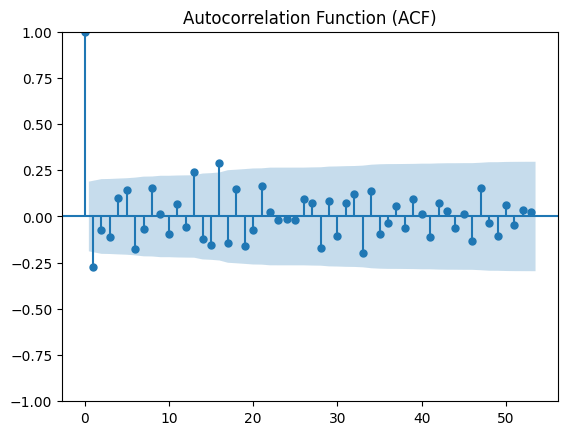

<Figure size 1200x600 with 0 Axes>

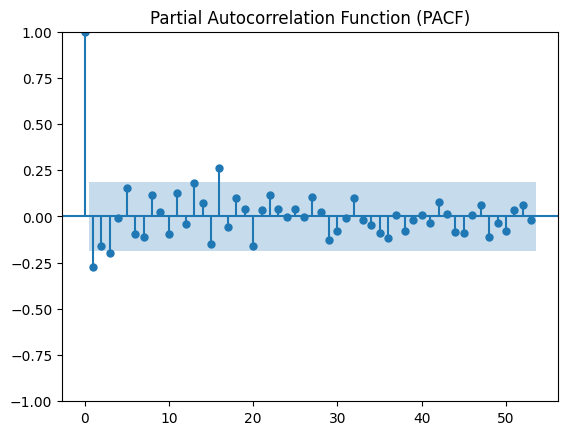


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -652.125
Date:                Thu, 10 Apr 2025   AIC                           1326.249
Time:                        21:58:14   BIC                           1355.753
Sample:                             0   HQIC                          1338.212
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2974      3.800      0.078      0.938      -7.150       7.745
ar.L2          0.3136      1.077      0.291      0.771      -1.797       2.4

<Figure size 1200x600 with 0 Axes>

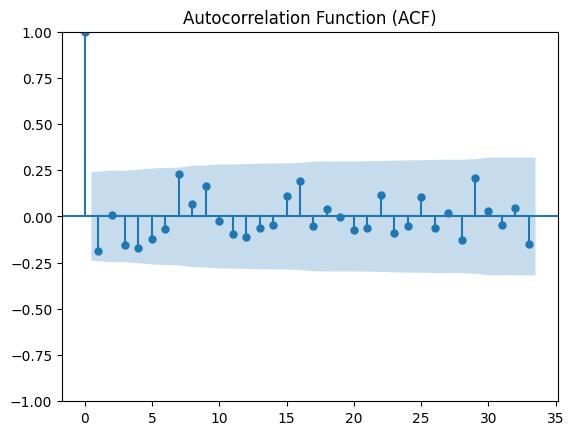

<Figure size 1200x600 with 0 Axes>

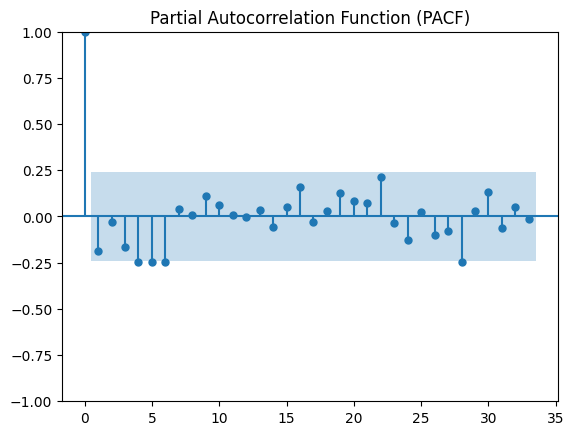


Fitting ARIMA model with order (5, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   68
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -476.088
Date:                Thu, 10 Apr 2025   AIC                            970.176
Time:                        21:58:19   BIC                            990.018
Sample:                             0   HQIC                           978.028
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5128      0.326      4.645      0.000       0.875       2.151
ar.L2         -1.2705      0.331     -3.833      0.000      -1.920      -0.6

<Figure size 1200x600 with 0 Axes>

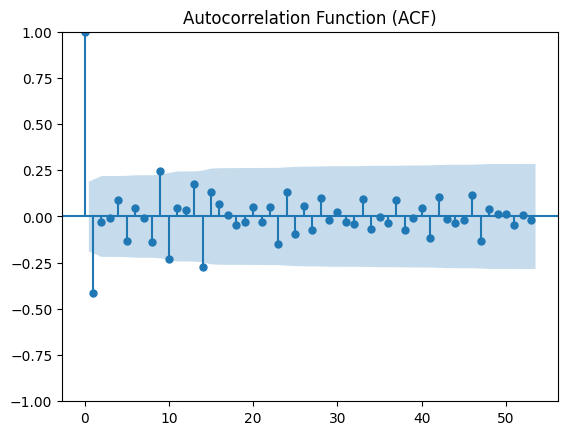

<Figure size 1200x600 with 0 Axes>

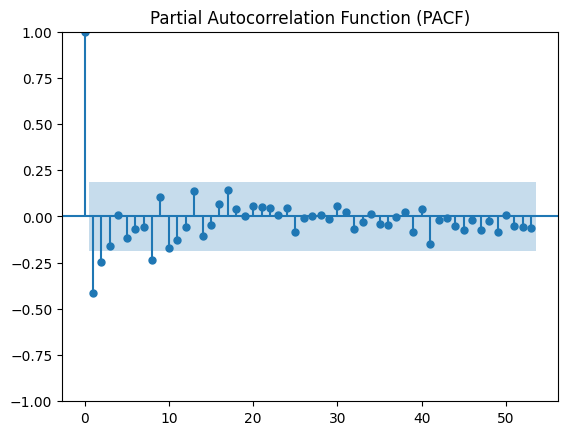


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -516.521
Date:                Thu, 10 Apr 2025   AIC                           1055.041
Time:                        21:58:27   BIC                           1084.545
Sample:                             0   HQIC                          1067.004
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3094      0.364      0.850      0.395      -0.404       1.023
ar.L2         -0.1199      0.247     -0.485      0.627      -0.604       0.3

<Figure size 1200x600 with 0 Axes>

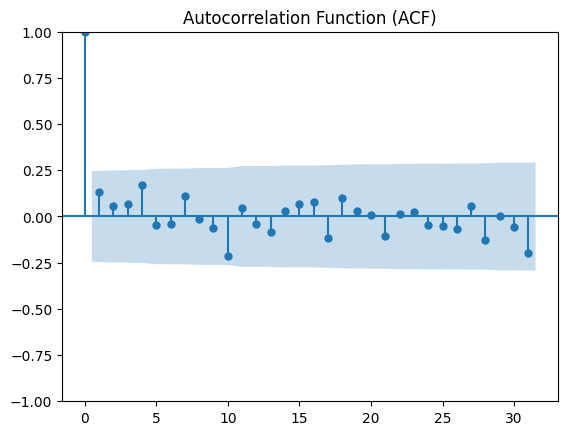

<Figure size 1200x600 with 0 Axes>

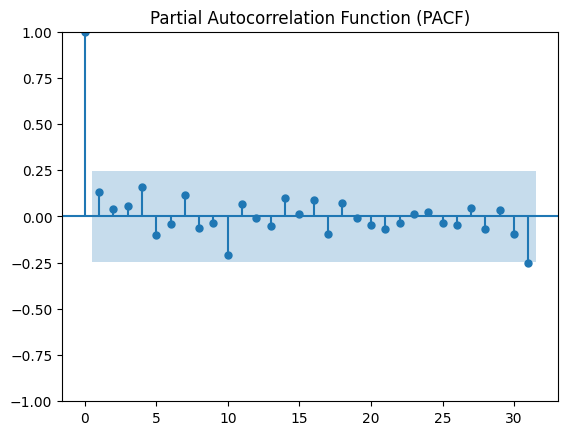


Fitting ARIMA model with order (2, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   64
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -376.592
Date:                Thu, 10 Apr 2025   AIC                            763.184
Time:                        21:58:34   BIC                            773.979
Sample:                             0   HQIC                           767.437
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        756.4810     14.195     53.290      0.000     728.658     784.304
ar.L1         -0.5125      8.938     -0.057      0.954     -18.031      17.0

<Figure size 1200x600 with 0 Axes>

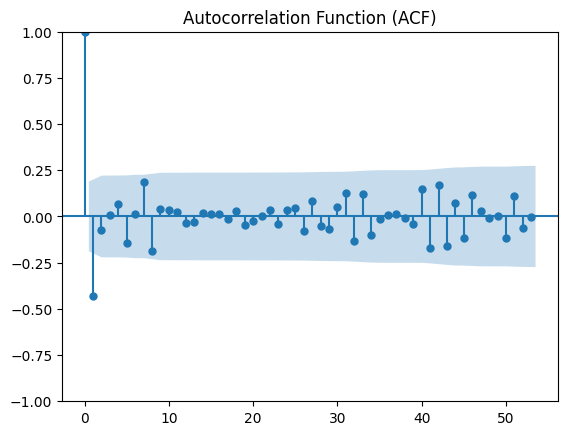

<Figure size 1200x600 with 0 Axes>

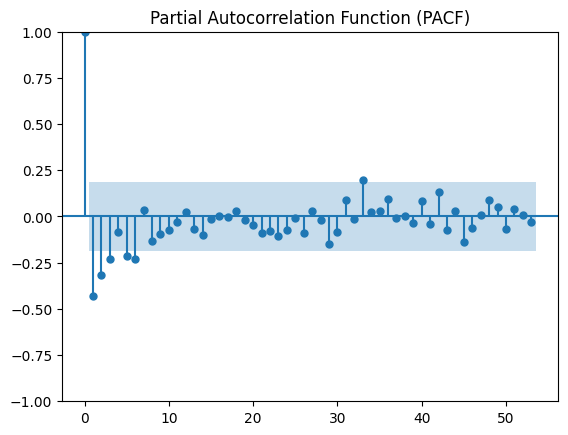


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -245.051
Date:                Thu, 10 Apr 2025   AIC                            504.103
Time:                        21:58:38   BIC                            522.878
Sample:                             0   HQIC                           511.716
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3874      0.122    -11.341      0.000      -1.627      -1.148
ar.L2         -0.8453      0.180     -4.691      0.000      -1.198      -0.4

<Figure size 1200x600 with 0 Axes>

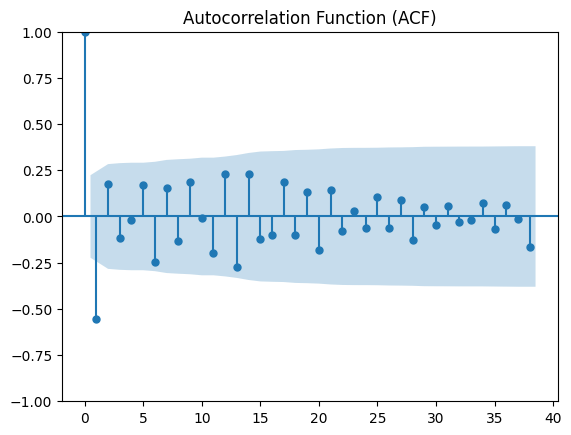

<Figure size 1200x600 with 0 Axes>

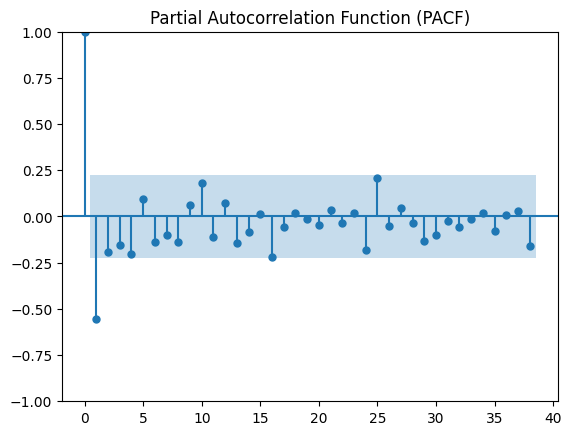


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   78
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -139.570
Date:                Thu, 10 Apr 2025   AIC                            297.141
Time:                        21:58:44   BIC                            318.235
Sample:                             0   HQIC                           305.578
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1217      0.286     -3.926      0.000      -1.682      -0.562
ar.L2         -1.1551      0.155     -7.446      0.000      -1.459      -0.8

<Figure size 1200x600 with 0 Axes>

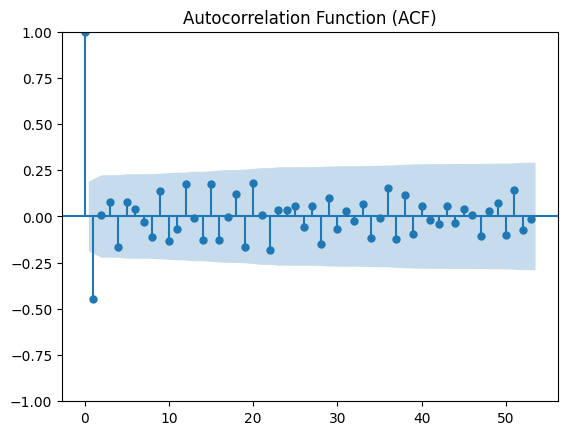

<Figure size 1200x600 with 0 Axes>

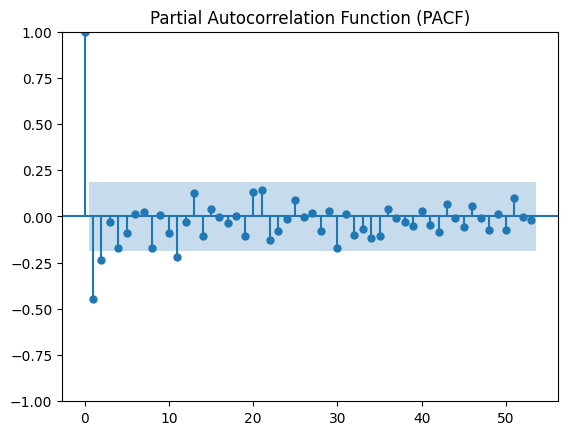


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -249.296
Date:                Thu, 10 Apr 2025   AIC                            520.592
Time:                        21:58:51   BIC                            550.095
Sample:                             0   HQIC                           532.555
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6289      0.480     -1.310      0.190      -1.570       0.312
ar.L2          0.3320      0.785      0.423      0.673      -1.207       1.8

<Figure size 1200x600 with 0 Axes>

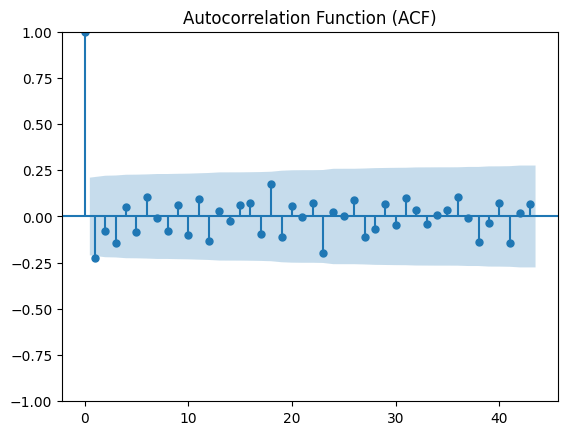

<Figure size 1200x600 with 0 Axes>

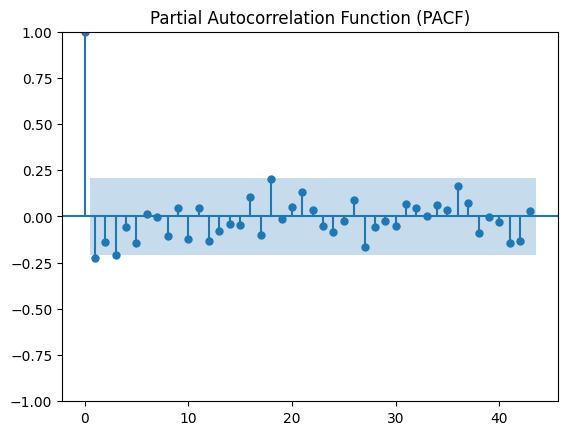


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   88
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -147.275
Date:                Thu, 10 Apr 2025   AIC                            308.551
Time:                        21:58:55   BIC                            325.812
Sample:                             0   HQIC                           315.502
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1313      0.172     -6.576      0.000      -1.468      -0.794
ar.L2         -0.0314      0.275     -0.114      0.909      -0.571       0.5

<Figure size 1200x600 with 0 Axes>

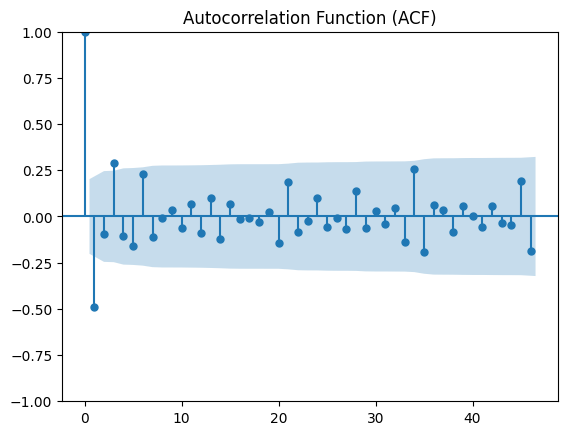

<Figure size 1200x600 with 0 Axes>

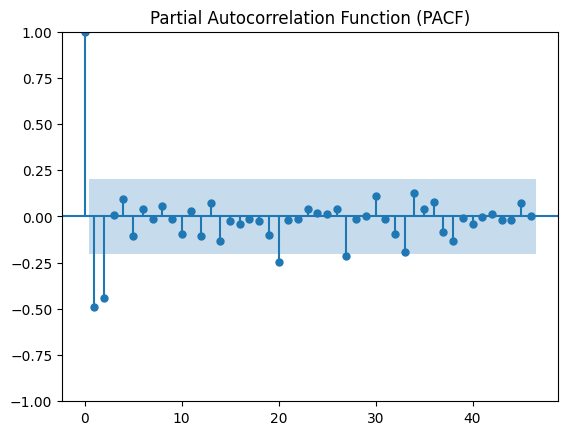


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   95
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -136.988
Date:                Thu, 10 Apr 2025   AIC                            283.976
Time:                        21:58:59   BIC                            296.693
Sample:                             0   HQIC                           289.113
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4681      0.143    -10.283      0.000      -1.748      -1.188
ar.L2         -0.4802      0.11

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ફોદીનો પુરા uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_2b294dd2ba094e95245802972b8139ef.pkl
પચકારુ size:  51
False
Checking stationarity for the raw price data of પચકારુ:

ADF Test Results:
ADF Statistic: -3.9278
p-value: 0.0018
Critical Value 1%: -3.5685
Critical Value 5%: -2.9214
Critical Value 10%: -2.5987
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.9278
p-value: 0.0018
Critical Value 1%: -3.5685
Critical Value 5%: -2.9214
Critical Value 10%: -2.5987
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 4 at lags [ 7 14 16 17]


<Figure size 1200x600 with 0 Axes>

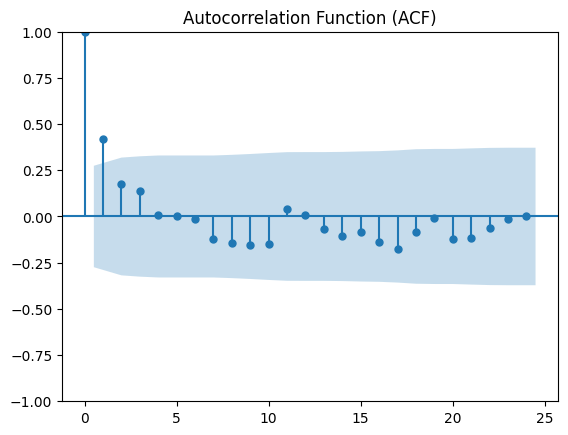

<Figure size 1200x600 with 0 Axes>

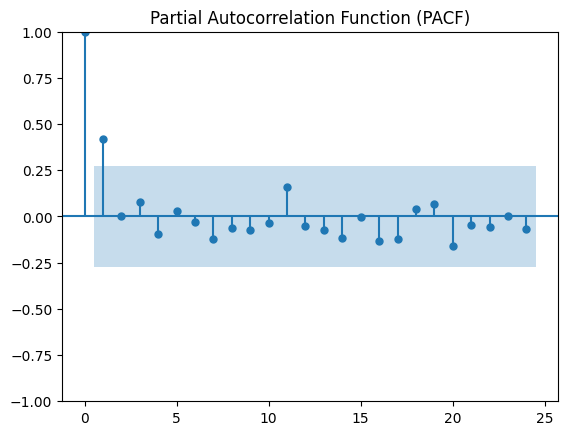


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   51
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -313.221
Date:                Thu, 10 Apr 2025   AIC                            638.442
Time:                        21:59:04   BIC                            650.033
Sample:                             0   HQIC                           642.871
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        441.6730     37.605     11.745      0.000     367.969     515.377
ar.L1          0.4895      0.178      2.752      0.006       0.141       0.8

<Figure size 1200x600 with 0 Axes>

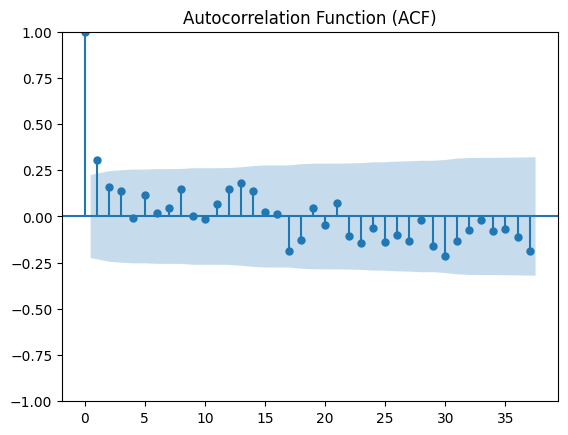

<Figure size 1200x600 with 0 Axes>

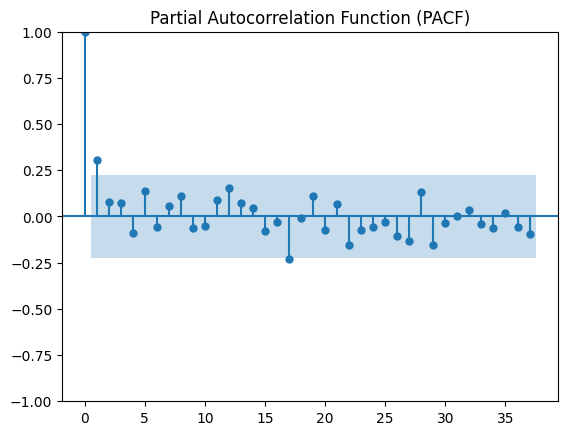


Fitting ARIMA model with order (1, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   76
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -489.559
Date:                Thu, 10 Apr 2025   AIC                            987.118
Time:                        21:59:07   BIC                            996.441
Sample:                             0   HQIC                           990.844
                                 - 76                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1094.5518     31.548     34.695      0.000    1032.718    1156.385
ar.L1          0.6047      0.30

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ચૂ્રણ uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_53a8c445bbc876962de0afa269bc4b91.pkl
ઘીસોડા size:  105
True
Checking stationarity for the raw price data of ઘીસોડા:

ADF Test Results:
ADF Statistic: -4.5599
p-value: 0.0002
Critical Value 1%: -3.4949
Critical Value 5%: -2.8898
Critical Value 10%: -2.5818
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5599
p-value: 0.0002
Critical Value 1%: -3.4949
Critical Value 5%: -2.8898
Critical Value 10%: -2.5818
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 4 at lags [ 4  8  9 18]


<Figure size 1200x600 with 0 Axes>

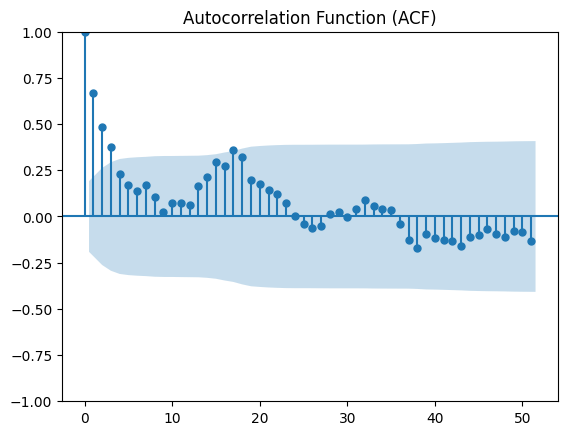

<Figure size 1200x600 with 0 Axes>

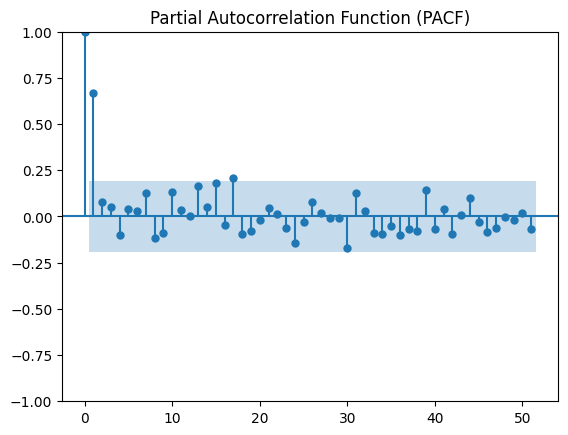


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -659.564
Date:                Thu, 10 Apr 2025   AIC                           1331.128
Time:                        21:59:11   BIC                           1347.051
Sample:                             0   HQIC                          1337.580
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        618.1516     69.866      8.848      0.000     481.216     755.087
ar.L1          0.5600      0.075      7.475      0.000       0.413       0.7

<Figure size 1200x600 with 0 Axes>

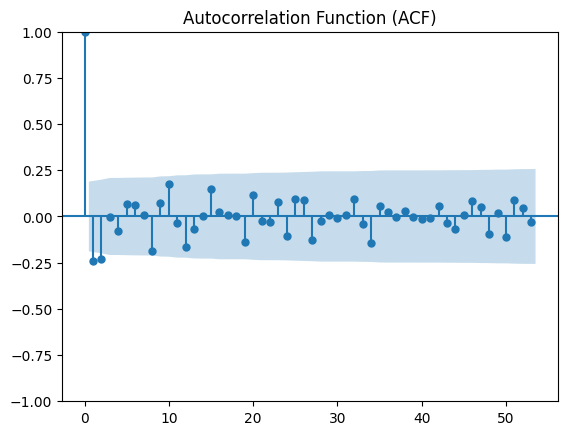

<Figure size 1200x600 with 0 Axes>

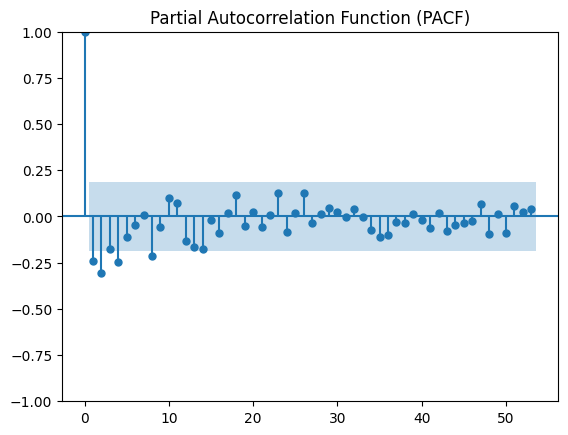


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -707.681
Date:                Thu, 10 Apr 2025   AIC                           1437.361
Time:                        21:59:17   BIC                           1466.865
Sample:                             0   HQIC                          1449.324
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6530      0.356      1.832      0.067      -0.045       1.351
ar.L2         -0.2101      0.332     -0.633      0.527      -0.861       0.4

<Figure size 1200x600 with 0 Axes>

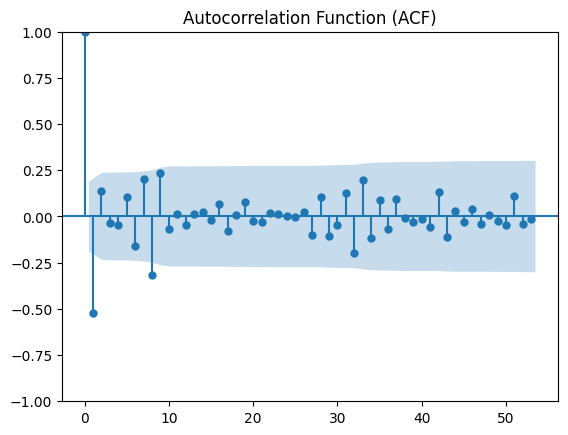

<Figure size 1200x600 with 0 Axes>

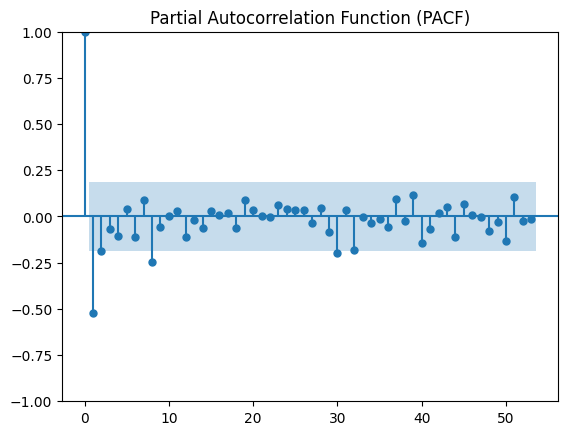


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -165.991
Date:                Thu, 10 Apr 2025   AIC                            345.981
Time:                        21:59:23   BIC                            364.756
Sample:                             0   HQIC                           353.594
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9585      0.694     -1.381      0.167      -2.319       0.402
ar.L2          0.2170      0.899      0.241      0.809      -1.544       1.9

<Figure size 1200x600 with 0 Axes>

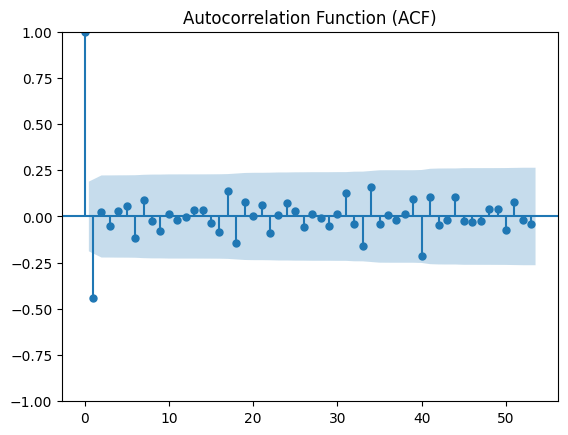

<Figure size 1200x600 with 0 Axes>

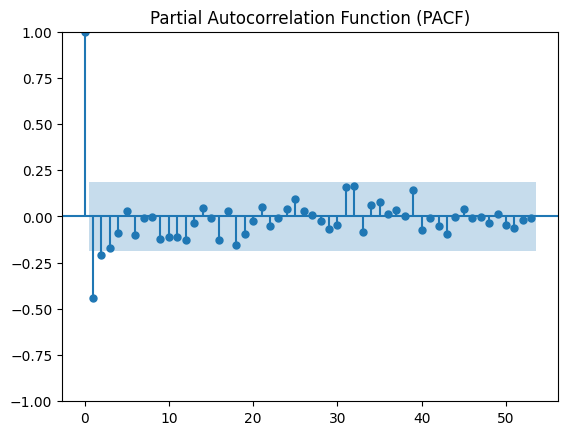


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -273.020
Date:                Thu, 10 Apr 2025   AIC                            560.040
Time:                        21:59:27   BIC                            578.815
Sample:                             0   HQIC                           567.653
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8566      0.141     -6.086      0.000      -1.132      -0.581
ar.L2         -0.8601      0.156     -5.527      0.000      -1.165      -0.5

<Figure size 1200x600 with 0 Axes>

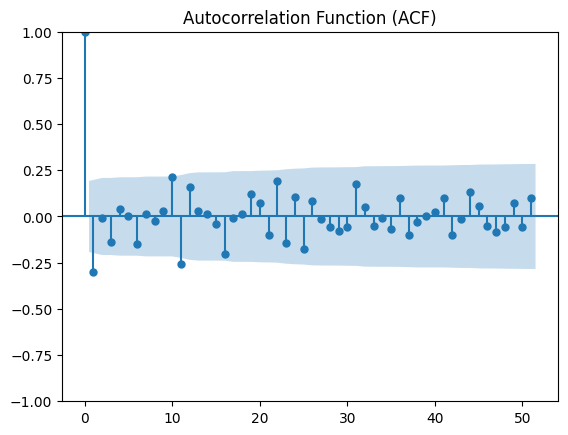

<Figure size 1200x600 with 0 Axes>

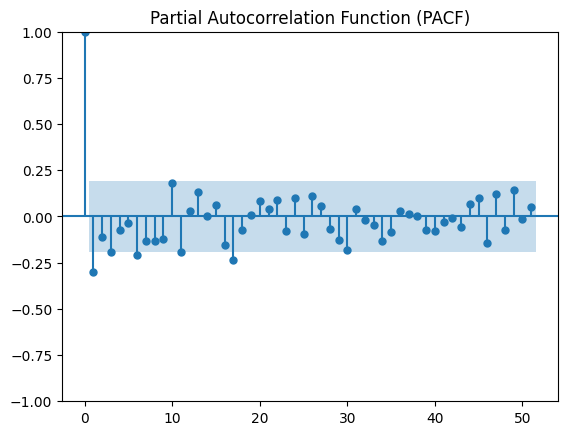


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -280.796
Date:                Thu, 10 Apr 2025   AIC                            583.592
Time:                        21:59:38   BIC                            612.680
Sample:                             0   HQIC                           595.376
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2325      0.230     -1.010      0.313      -0.684       0.219
ar.L2         -0.3907      0.249     -1.570      0.117      -0.879       0.0

<Figure size 1200x600 with 0 Axes>

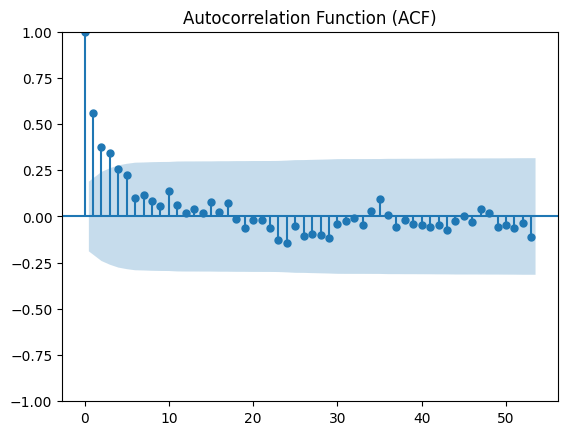

<Figure size 1200x600 with 0 Axes>

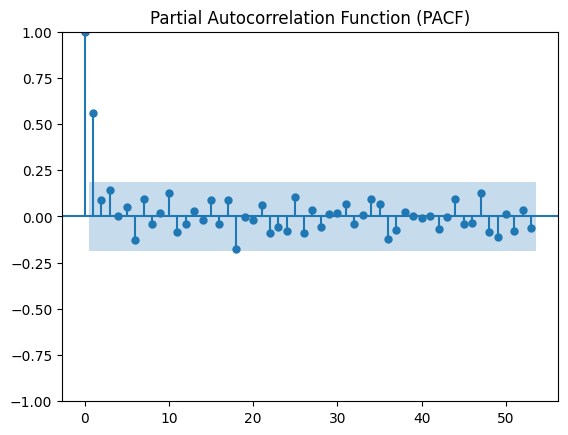


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -634.790
Date:                Thu, 10 Apr 2025   AIC                           1279.579
Time:                        21:59:43   BIC                           1292.990
Sample:                             0   HQIC                          1285.017
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        575.9359     26.922     21.392      0.000     523.169     628.703
ar.L1          0.4927      0.10

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ચોરા uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_b14c8f5cbd856d7fd800c8c3ab40ad69.pkl
કારેલા size:  103
False
Checking stationarity for the raw price data of કારેલા:

ADF Test Results:
ADF Statistic: -4.7674
p-value: 0.0001
Critical Value 1%: -3.4968
Critical Value 5%: -2.8906
Critical Value 10%: -2.5823
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7674
p-value: 0.0001
Critical Value 1%: -3.4968
Critical Value 5%: -2.8906
Critical Value 10%: -2.5823
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [11]
Significant spikes in PACF (p): 3 at lags [ 6 11 20]


<Figure size 1200x600 with 0 Axes>

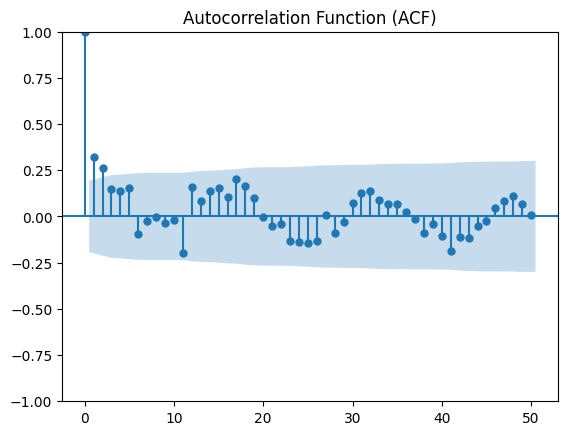

<Figure size 1200x600 with 0 Axes>

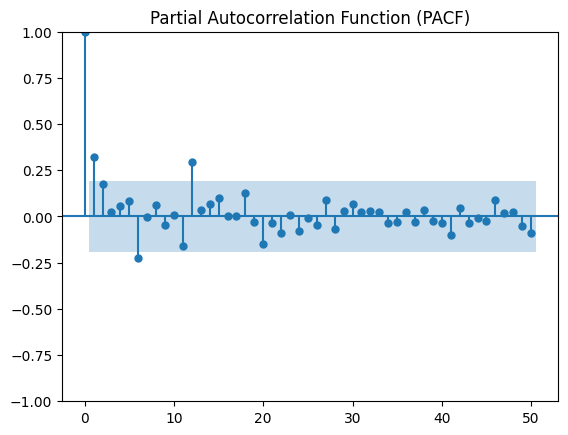


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  103
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -604.937
Date:                Thu, 10 Apr 2025   AIC                           1221.874
Time:                        21:59:49   BIC                           1237.682
Sample:                             0   HQIC                          1228.277
                                - 103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        555.6002     17.391     31.948      0.000     521.515     589.686
ar.L1          0.6436      2.391      0.269      0.788      -4.043       5.3

<Figure size 1200x600 with 0 Axes>

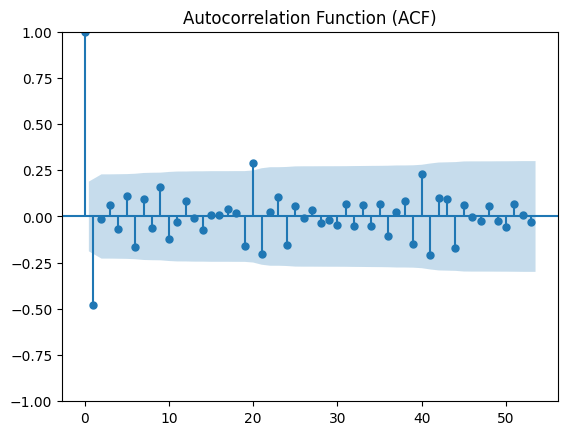

<Figure size 1200x600 with 0 Axes>

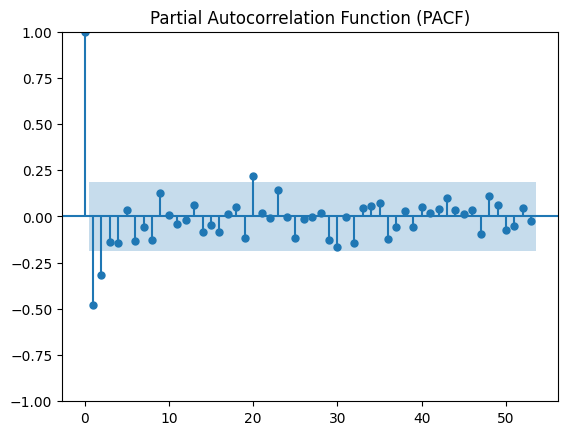


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -671.142
Date:                Thu, 10 Apr 2025   AIC                           1360.284
Time:                        21:59:55   BIC                           1384.423
Sample:                             0   HQIC                          1370.072
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8410      7.258      0.116      0.908     -13.385      15.067
ar.L2          0.9352      0.565      1.656      0.098      -0.172       2.0

<Figure size 1200x600 with 0 Axes>

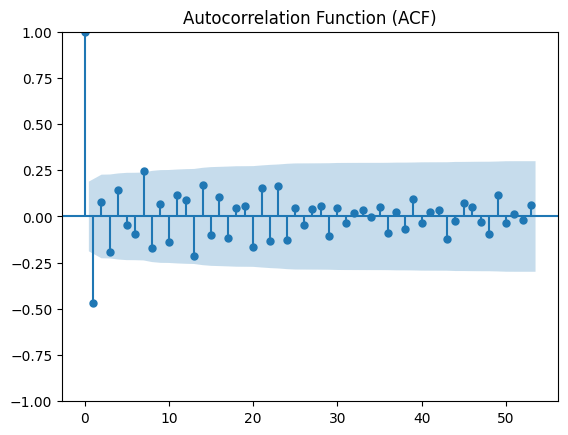

<Figure size 1200x600 with 0 Axes>

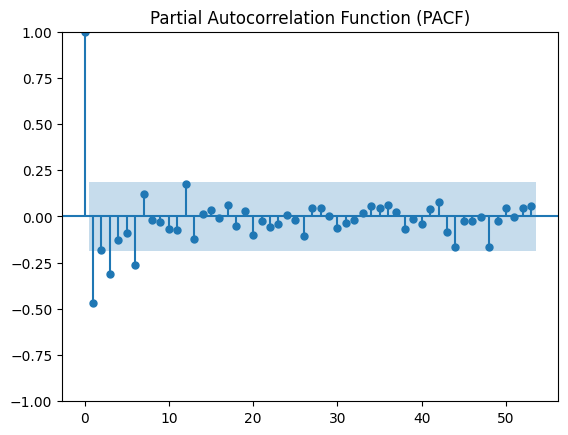


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -595.093
Date:                Thu, 10 Apr 2025   AIC                           1212.186
Time:                        21:59:59   BIC                           1241.689
Sample:                             0   HQIC                          1224.148
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0717      0.213     -0.337      0.736      -0.489       0.346
ar.L2          0.5002      0.157      3.189      0.001       0.193       0.8

<Figure size 1200x600 with 0 Axes>

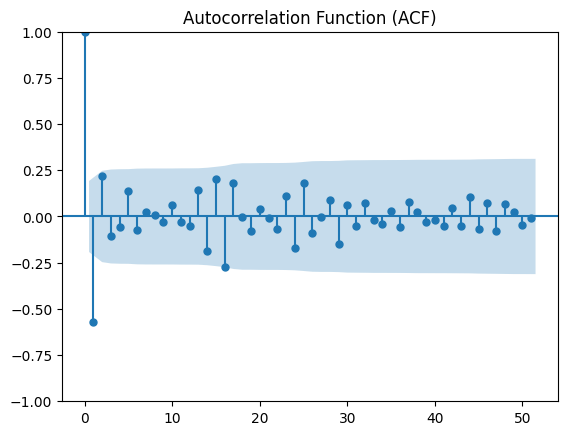

<Figure size 1200x600 with 0 Axes>

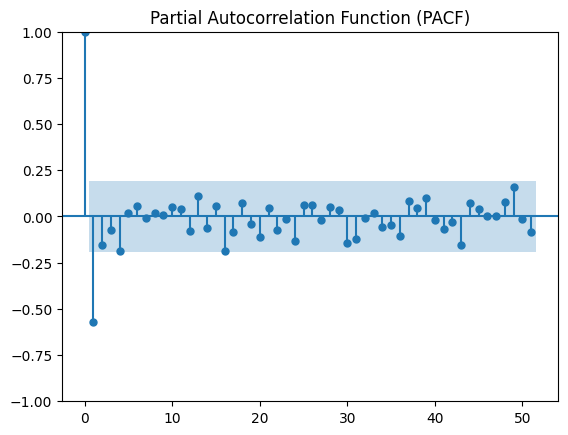


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -520.707
Date:                Thu, 10 Apr 2025   AIC                           1055.413
Time:                        22:00:09   BIC                           1073.924
Sample:                             0   HQIC                          1062.912
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7372      0.705     -1.045      0.296      -2.120       0.645
ar.L2         -0.5354      0.820     -0.653      0.514      -2.143       1.0

<Figure size 1200x600 with 0 Axes>

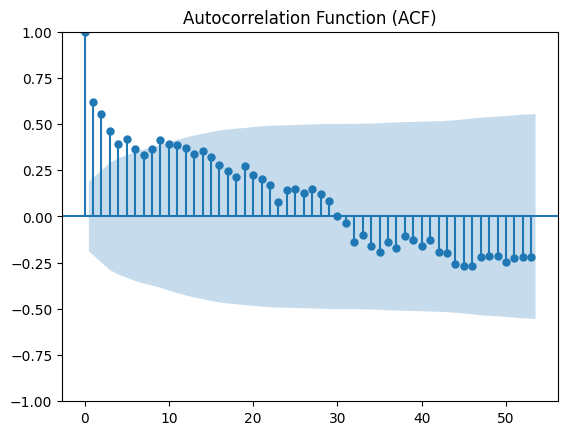

<Figure size 1200x600 with 0 Axes>

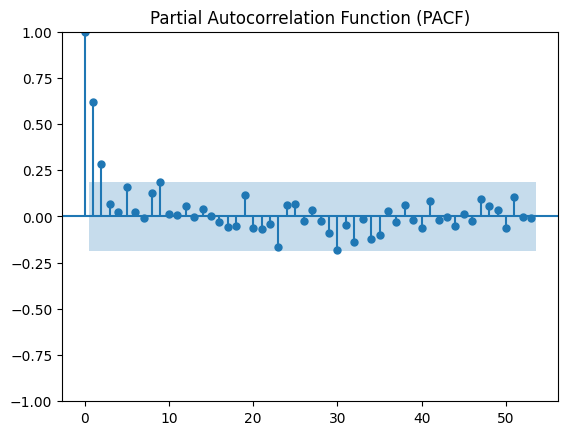


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                          ARIMA   Log Likelihood                -360.069
Date:                Thu, 10 Apr 2025   AIC                            724.138
Time:                        22:00:18   BIC                            729.521
Sample:                             0   HQIC                           726.321
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6284      0.788     27.448      0.000      20.084      23.173
sigma2        43.3322      6.03

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for લસણ પુરા uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_ea48f7e71ae1c5d9de5a6b5a5eb47f49.pkl
પાલક પુરા size:  109
True
Checking stationarity for the raw price data of પાલક પુરા:

ADF Test Results:
ADF Statistic: -1.5528
p-value: 0.5072
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.7998
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.7998
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 7 at lags [ 1  3  5 10 14 16 18]
Significant spikes in PACF (p): 8 at lags [ 1  2  3  5

<Figure size 1200x600 with 0 Axes>

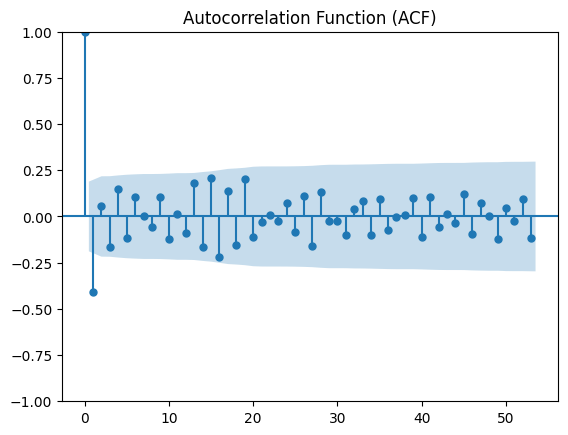

<Figure size 1200x600 with 0 Axes>

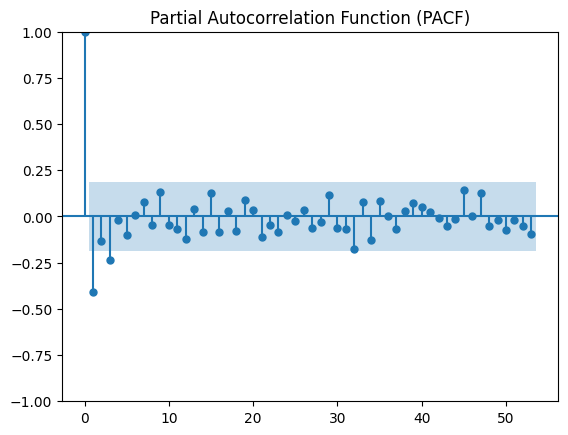


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -153.236
Date:                Thu, 10 Apr 2025   AIC                            328.472
Time:                        22:00:23   BIC                            357.976
Sample:                             0   HQIC                           340.435
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6707      0.953      0.704      0.481      -1.196       2.538
ar.L2         -0.4908      1.324     -0.371      0.711      -3.087       2.1

<Figure size 1200x600 with 0 Axes>

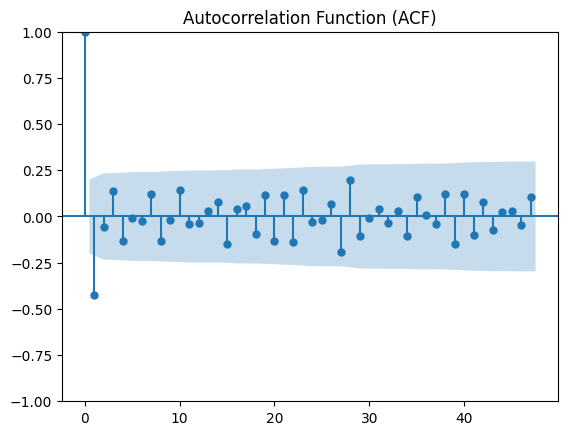

<Figure size 1200x600 with 0 Axes>

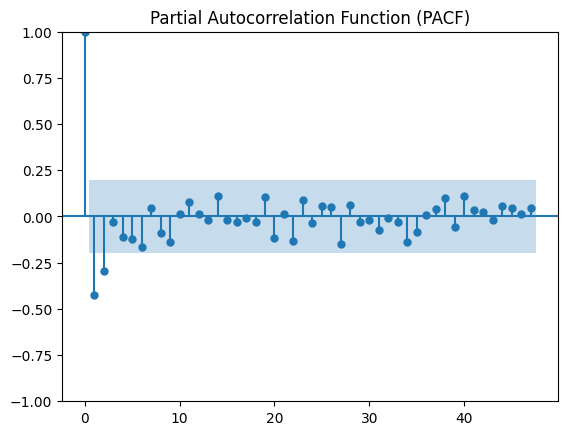


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   97
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -596.268
Date:                Thu, 10 Apr 2025   AIC                           1210.536
Time:                        22:00:30   BIC                           1233.615
Sample:                             0   HQIC                          1219.865
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7242      0.140      5.183      0.000       0.450       0.998
ar.L2         -0.6226      0.096     -6.480      0.000      -0.811      -0.4

<Figure size 1200x600 with 0 Axes>

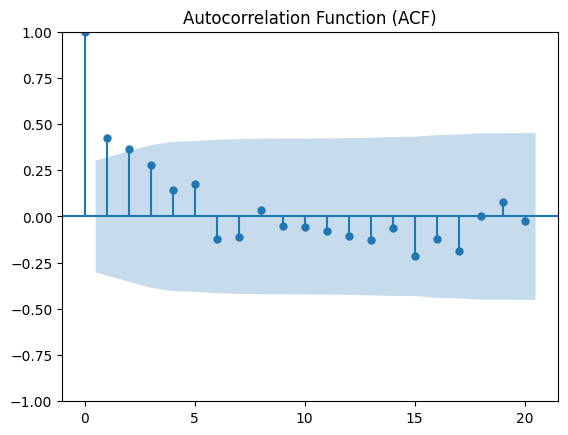

<Figure size 1200x600 with 0 Axes>

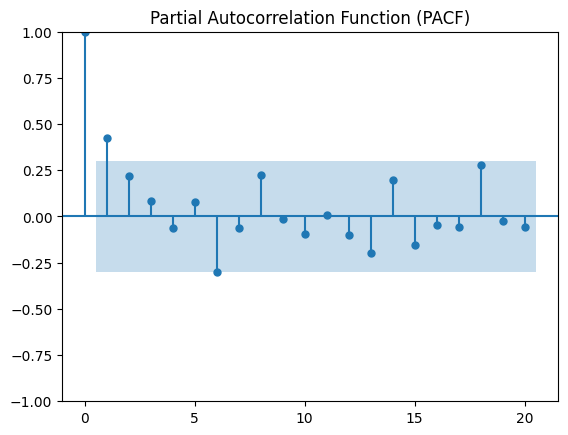


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   42
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -246.749
Date:                Thu, 10 Apr 2025   AIC                            503.497
Time:                        22:00:34   BIC                            512.186
Sample:                             0   HQIC                           506.682
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        565.2830     42.297     13.365      0.000     482.383     648.183
ar.L1          0.3248      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for અંબાળા uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_d77da01ab7065105c3d353804f60f1f5.pkl
કાચા કેળા size:  64
False
Checking stationarity for the raw price data of કાચા કેળા:

ADF Test Results:
ADF Statistic: -4.5346
p-value: 0.0002
Critical Value 1%: -3.5387
Critical Value 5%: -2.9086
Critical Value 10%: -2.5919
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5346
p-value: 0.0002
Critical Value 1%: -3.5387
Critical Value 5%: -2.9086
Critical Value 10%: -2.5919
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 3 at lags [12 14 15]


<Figure size 1200x600 with 0 Axes>

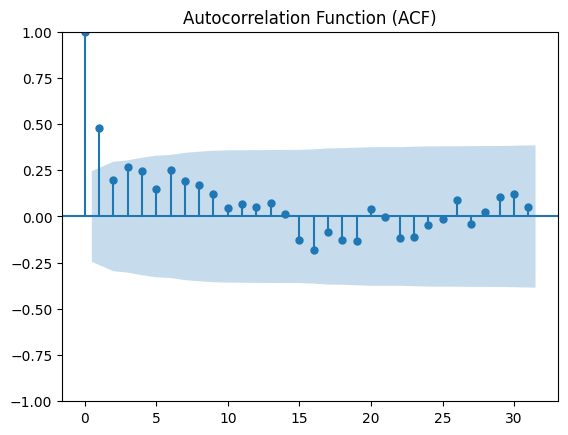

<Figure size 1200x600 with 0 Axes>

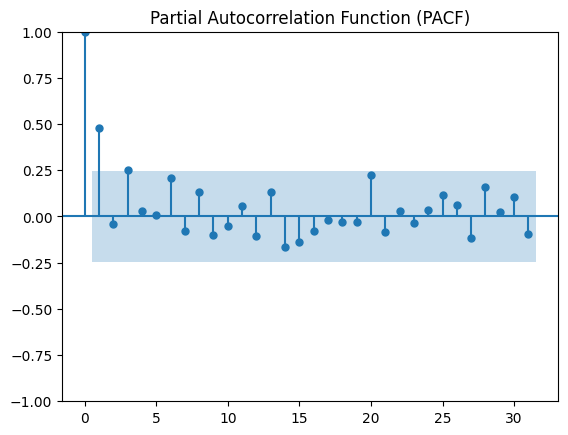


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   64
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -369.118
Date:                Thu, 10 Apr 2025   AIC                            748.236
Time:                        22:00:38   BIC                            759.031
Sample:                             0   HQIC                           752.489
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.8855     27.458     13.762      0.000     324.069     431.702
ar.L1          0.5423      0.146      3.717      0.000       0.256       0.8

<Figure size 1200x600 with 0 Axes>

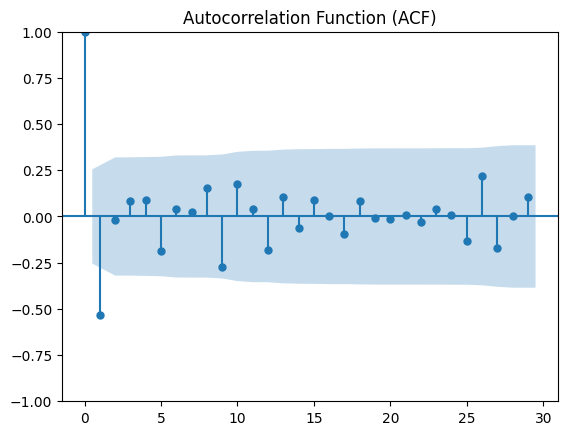

<Figure size 1200x600 with 0 Axes>

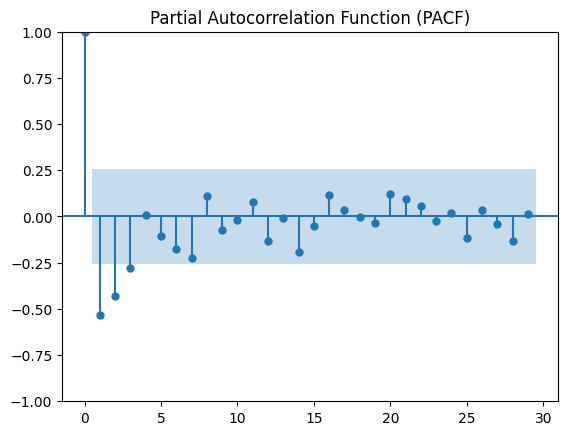


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   60
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -308.546
Date:                Thu, 10 Apr 2025   AIC                            635.092
Time:                        22:00:41   BIC                            653.790
Sample:                             0   HQIC                           642.391
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7735      0.689     -1.122      0.262      -2.125       0.578
ar.L2         -0.6887      0.343     -2.010      0.044      -1.360      -0.0

<Figure size 1200x600 with 0 Axes>

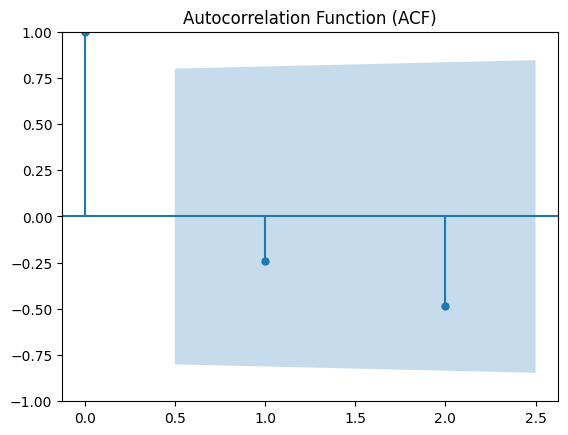

<Figure size 1200x600 with 0 Axes>

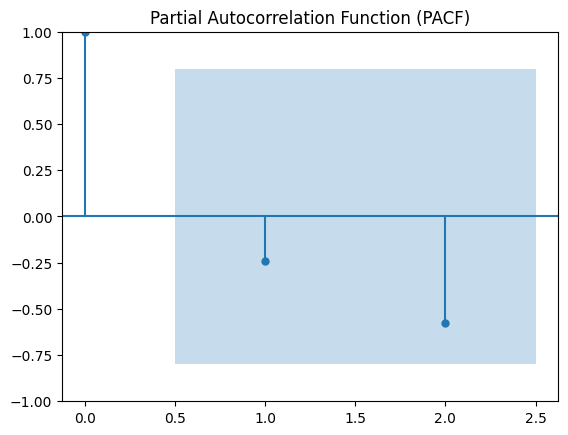


Fitting ARIMA model with order (1, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    6
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -18.518
Date:                Thu, 10 Apr 2025   AIC                             45.036
Time:                        22:00:45   BIC                             44.203
Sample:                             0   HQIC                            41.701
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8531      1.096     16.288      0.000      15.705      20.001
ar.L1          0.0091      1.44

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for લીમડો પુરા uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_d913c68c220da9980eebb79c73cc78a2.pkl
parvar size:  13
False
Checking stationarity for the raw price data of parvar:

ADF Test Results:
ADF Statistic: -2.5236
p-value: 0.1098
Critical Value 1%: -4.2232
Critical Value 5%: -3.1894
Critical Value 10%: -2.7298
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: 1.8386
p-value: 0.9984
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.7955
p-value: 0.0001
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7955
p-value: 0.0001
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Valu

<Figure size 1200x600 with 0 Axes>

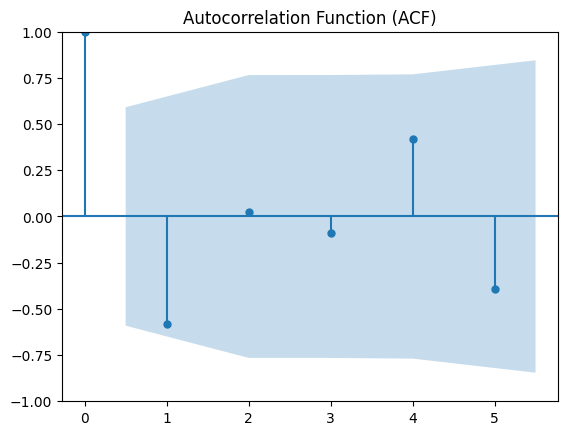

<Figure size 1200x600 with 0 Axes>

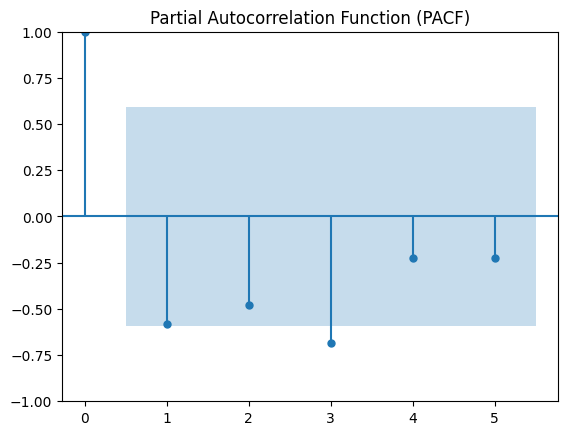


Fitting ARIMA model with order (3, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   13
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 -74.201
Date:                Thu, 10 Apr 2025   AIC                            158.403
Time:                        22:00:47   BIC                            160.392
Sample:                             0   HQIC                           157.149
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7975      0.278     -2.867      0.004      -1.343      -0.252
ar.L2         -0.6786      0.27

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for parvar uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_a508f0e1c78b869b9625a84190a881c8.pkl
ફણશી size:  28
False
Checking stationarity for the raw price data of ફણશી:

ADF Test Results:
ADF Statistic: -4.9457
p-value: 0.0000
Critical Value 1%: -3.6996
Critical Value 5%: -2.9764
Critical Value 10%: -2.6276
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.9457
p-value: 0.0000
Critical Value 1%: -3.6996
Critical Value 5%: -2.9764
Critical Value 10%: -2.6276
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [7]
Significant spikes in PACF (p): 5 at lags [ 6  7  8 10 12]


<Figure size 1200x600 with 0 Axes>

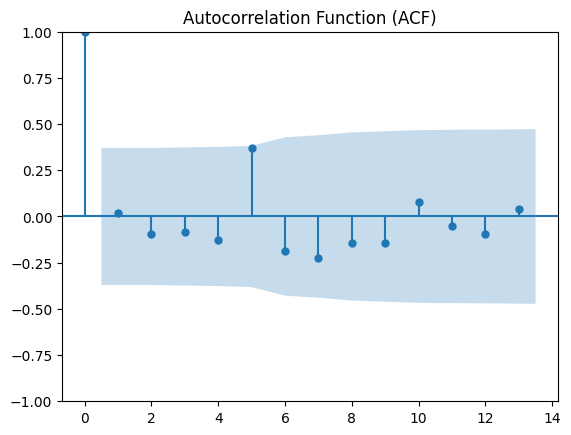

<Figure size 1200x600 with 0 Axes>

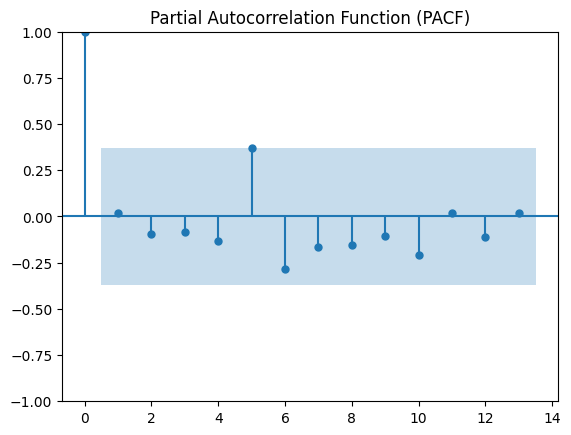


Fitting ARIMA model with order (5, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   28
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -192.967
Date:                Thu, 10 Apr 2025   AIC                            401.934
Time:                        22:00:50   BIC                            412.592
Sample:                             0   HQIC                           405.193
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1639.2124    121.421     13.500      0.000    1401.232    1877.193
ar.L1         -0.2345      0.813     -0.288      0.773      -1.827       1.3

<Figure size 1200x600 with 0 Axes>

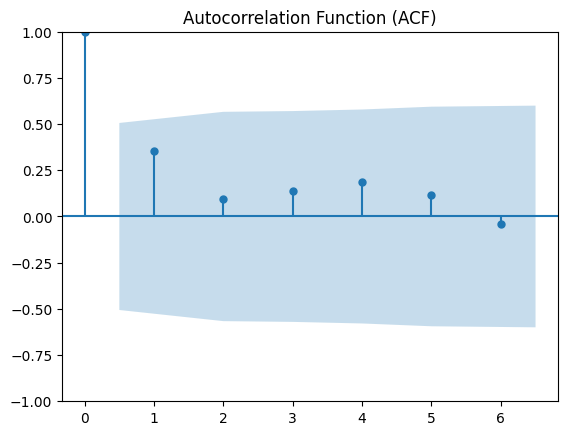

<Figure size 1200x600 with 0 Axes>

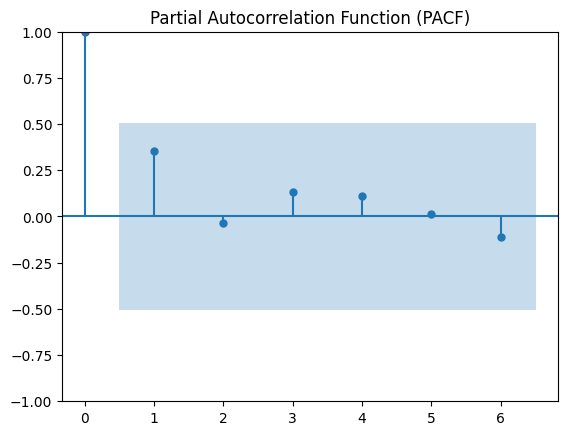


Fitting ARIMA model with order (0, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   15
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -88.020
Date:                Thu, 10 Apr 2025   AIC                            182.040
Time:                        22:00:55   BIC                            184.164
Sample:                             0   HQIC                           182.017
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        166.8761     41.085      4.062      0.000      86.352     247.400
ma.L1          0.6354      0.20

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for શેરડી uploaded to Spaces at ml_models/vegetables_saved_models/arima_model_e7f9e460d7f49d681ba5054e76a0e5ae.pkl
મગફળી લીલી size:  1
ગુંદા size:  17
False
Checking stationarity for the raw price data of ગુંદા:

ADF Test Results:
ADF Statistic: -2.6037
p-value: 0.0922
Critical Value 1%: -4.3316
Critical Value 5%: -3.2330
Critical Value 10%: -2.7487
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.4049
p-value: 0.1403
Critical Value 1%: -4.4731
Critical Value 5%: -3.2899
Critical Value 10%: -2.7724
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.5028
p-value: 0.1148
Critical Value 1%: -4.4731
Critical Value 5%: -3.2899
Critical Value 10%: -2.7724
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.1520
p-value: 0.0000
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is stationary (no further differencing n

<Figure size 1200x600 with 0 Axes>

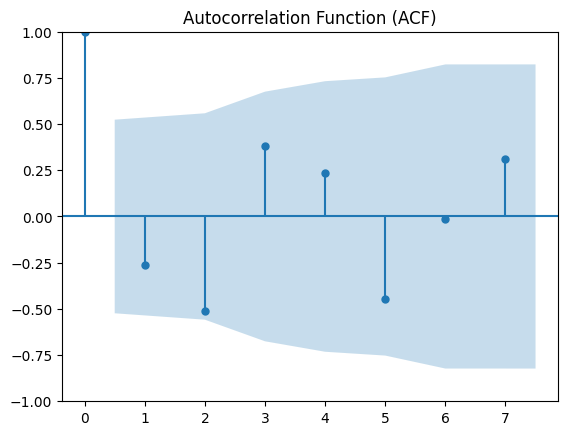

<Figure size 1200x600 with 0 Axes>

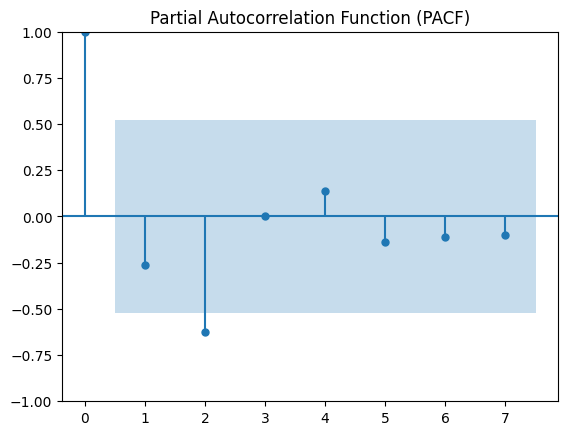


Fitting ARIMA model with order (4, 3, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                 ARIMA(4, 3, 2)   Log Likelihood                 -95.643
Date:                Thu, 10 Apr 2025   AIC                            205.285
Time:                        22:00:58   BIC                            209.759
Sample:                             0   HQIC                           204.871
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3412      0.096    -13.960      0.000      -1.530      -1.153
ar.L2         -1.1454      0.153     -7.499      0.000      -1.445      -0.8

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
import boto3
import io
from dotenv import load_dotenv
load_dotenv()


###------------------------------------------------------------------------------------------------------------------------------
# Setup your DigitalOcean Spaces client
def get_spaces_client():
    return boto3.client(
        's3',
        region_name=os.getenv("SPACES_REGION"),
        endpoint_url=os.getenv("SPACES_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("SPACES_ACCESS_KEY"),
        aws_secret_access_key=os.getenv("SPACES_SECRET_KEY")
    )

def dump_model_to_spaces(model, product, category):
    try:
        # Prepare filename
        hashed_name = safe_filename(product)
        filename = f"arima_model_{hashed_name}.pkl"
        key = f"ml_models/{category}/{filename}"  
        bucket = os.getenv("SPACES_BUCKET_NAME")
        print(f"Uploading to bucket: {bucket} with key: {key}")

        # Serialize model to bytes
        bytes_buffer = io.BytesIO()
        joblib.dump(model, bytes_buffer)
        bytes_buffer.seek(0)

        # Upload to Spaces
        client = get_spaces_client()
        client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=bytes_buffer)

        print(f"Model for {product} uploaded to Spaces at {key}")
    except Exception as e:
        print(f"Error uploading model for {product} to Spaces: {e}")
        

def filterData(existing_data):
    data = existing_data
    
    # Get current date and calculate the cutoff date (4 months ago)
    current_date = datetime.today()
    cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
    cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

    # today_date = datetime.now().strftime("%d/%m/%Y")

    # Filter data to keep only the last 4 months
    filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]
    
    return filtered_data


def append_csv_to_spaces(new_df: pd.DataFrame, filename: str):
    client = get_spaces_client()
    key = f"data/vegetables/{filename}"

    try:
        # Step 1: Download existing file if it exists
        existing = client.get_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key)
        existing_data = pd.read_csv(existing['Body'])
        print("📥 Existing CSV loaded from Spaces.")
        
        if(filename == "vegetables_price_data.csv"):
            existing_data = filterData(existing_data)
            

        # Step 2: Append new data
        combined_df = pd.concat([existing_data, new_df], ignore_index=True)

    except client.exceptions.NoSuchKey:
        print("ℹ️ No existing file found. Creating a new one.")
        combined_df = new_df

    # Step 3: Upload updated CSV
    csv_buffer = io.StringIO()
    combined_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=csv_buffer.getvalue())

    print(f"✅ CSV saved to Spaces at {key}")



products_with_boxcox = []
### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/vegetables/vegetables_price_data.csv"


# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/vegetables_saved_models"
filename = base_dir / "ml_models/vegetables_saved_models/vegetables_parameters.csv"
allYearsFilename = base_dir / "data/vegetables/vegetables_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
# filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)
        
        
        columns = ["Date", "Some Extra Column", "Item Name", "Low Price", "Average Price", "High Price"]
        new_df = pd.DataFrame(data, columns=columns)
        print("Before dropping the column:")
        print(new_df.head())
        

        # Drop the column at index 1 (which corresponds to "Item Name")
        new_df.drop(new_df.columns[1], axis=1, inplace=True)
        
        print("\nAfter dropping the column:")
        print(new_df.head())
        
        new_df['Average Price'], new_df['High Price'] = new_df['High Price'], new_df['Average Price']

        # Print the new DataFrame to verify
        print("\nAfter rearranging the column:")
        print(new_df.head())


        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        append_csv_to_spaces(new_df, "vegetables_price_data.csv")
        write_to_csv(data, allYearsFilename)
        append_csv_to_spaces(new_df, "vegetables_price_data-all_years.csv")
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("VEGETABLES_WEBPAGE_PATH"),
                                            os.getenv("VEGETABLES_DATE_PATH"),
                                            os.getenv("VEGETABLES_SUBMIT_BUTTON_PATH"),
                                            os.getenv("VEGETABLES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            dump_model_to_spaces(model_fit, product, "vegetables_saved_models")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
